In [38]:
#%pip install statsmodels
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import statsmodels.api as sm

stocks = pd.read_csv("C:/Users/adamt/OneDrive/Desktop/Jakub/masterThesis/stocks.csv",index_col = 0)
#portfolio = pd.read_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/test_files/select_cointegrated_pairs_test_result.csv",index_col = 0)
stocks_formation = stocks[:100]
stocks_trading = stocks[101:250]

def estimate_model(stocks_formation, portfolio):
    """
    Parameters: should be portfolio and stocks formation, 
    Y observed is defined as logx1 - logx2.
    Takes formation period spread (= observed y) and learns the parameters of the state-observation model (A,B,C,D) using EM algorithm.
    Estimates the model for each pair of the trading portfolio in the formation period.
    """
    portfolio_models = pd.DataFrame(columns=["A", "B", "C", "D"])

    for pair in portfolio.index:
        
        stock1, stock2 = pair.split("_")
        print("processing pair ", stock1, "and", stock2)
        
       

        
        # Spread= logP2 - logP1
        y_obs = np.log(stocks_formation[stock1]/stocks_formation[stock2])

        # Define the Kalman Filter
        kf = KalmanFilter(
            n_dim_obs=1, 
            n_dim_state=1, 
            em_vars=['transition_matrices', 'transition_offsets', 
                    'transition_covariance', 'observation_covariance']
        )

        print("estimating model....")

        # Estimate Parameters Using EM
        kf = kf.em(y_obs, n_iter=20)

        # Extract Learned Parameters
        A_est = kf.transition_offsets       # Estimated A
        B_est = kf.transition_matrices      # Estimated B
        C_est = np.sqrt(kf.transition_covariance)  # Estimated C (since Q = C^2)
        D_est = np.sqrt(kf.observation_covariance)  # Estimated D (since R = D^2)


        portfolio_models.loc[pair, "A"] = A_est.item()
        portfolio_models.loc[pair, "B"] = B_est.item()
        portfolio_models.loc[pair, "C"] = C_est.item()
        portfolio_models.loc[pair, "D"] = D_est.item()
        print("params of the spread for :", pair, "are ", A_est.item(), B_est.item(), C_est.item(), D_est.item())
      
        
    return portfolio_models


portfolio = pd.DataFrame(index=["KO_PEP"], columns=["beta", "mean", "sd"])

portfolio_model = estimate_model(stocks_formation=stocks_formation,portfolio=portfolio)


processing pair  KO and PEP
estimating model....
params of the spread for : KO_PEP are  -0.37467243444783105 0.5742959664389676 0.005568496483323528 0.0036403393028070423


In [ ]:
def trade_portfolio_kalman(portfolio_model, stocks_trading):
    """ 
    This performs the recursive kalman filter based on the parameterss A,B,C,D state-observation model estimated before.
    Takes the trading period stocks and performs the trading algorithm 
    """
    result_df = pd.DataFrame(index = stocks_trading.index)

    # Process each pair
    for pair in portfolio_model.index:
        entered_trade = False
        stock1, stock2 = pair.split("_")

        print("proccesing pair: \n",  pair, "\n", 100*"-")
        A,B,C,D = portfolio_model.loc[pair]
       

        # spread for a given pair
        y_obs = np.log(stocks_trading[stock1]/stocks_trading[stock2])
       
        # x0 = y0 
        x_est = [y_obs.iloc[0]]  
        R_est = [D**2]
        K_hist  = [(B**2) * R_est[-1] + C**2  / ((B**2) * R_est[-1] + C**2 + D**2)]

        print("Params A,B,C,D are", A,B,C,D, "\n first few y obs")
        print(y_obs)
        
        pair_result = {}
        spread_t = 0
        pair_result[y_obs.index[0]] = 0.0
        
        print("Current observed spread is: ",  y_obs.iloc[0], "and Current filtered spread is", x_est[0])
        
        # Direction variable 1 long -1 short 

        direction = 0

        # proces spread each day for this pair 
        for i in range(1, len(y_obs.index)):
            
            date = stocks_trading.index[i]

            # y observed
            observed_y = y_obs.iloc[i] 

            # Kalman Filter recursion
            x = A + B * x_est[-1]
            R = (B**2) * R_est[-1] + C**2
            K = R / (R + D**2)
            x_hat = x + K * (observed_y - x)
            R_hat = (D**2) * K
            #R_hat = float((1 - K) * R)
            
            x_est.append(x_hat)
            R_est.append(R_hat)
            K_hist.append(K)

            print(40*"-", "\nprocessing date", date)
            print("Current observed spread is: ",  y_obs.iloc[i], "and Current filtered spread is", x_est[i])

            # trade logic here, we compare prediction and signal 
            threshold = np.sqrt(R_hat) * 1 # threshold to enter the trade
            
            if observed_y > x_hat + threshold and not entered_trade:
                #observed spread is too large, enter trade 
                print("Observed spread ",observed_y ," is too big, short trade entered...")
                spread_t = observed_y
                direction = -1
                entered_trade = True
            
            elif observed_y < x_hat - threshold and not entered_trade:
                # observed spread is too small, enter trade 
                print("Observed spread is too small, long trade entered...")
                spread_t = observed_y
                direction = +1
                entered_trade = True

            # if the spread at time t was higher and 
            # current spread returns to 0, exit and save delta_spread = spread_t+n - spread_t
            if direction == -1 and observed_y < x_hat and entered_trade:
                print("Short trade was exited...return is :", abs(observed_y - spread_t))    
                entered_trade = False   # exit trade
                
                delta_spread = abs(observed_y - spread_t) # return = delta spread
            elif direction == +1 and observed_y > x_hat and entered_trade:
                print("Long trade was exited...return is :", abs(observed_y - spread_t))    
                entered_trade = False   # exit trade
                delta_spread = abs(observed_y - spread_t) # return = delta spread
            else: 
                # if trade is not entered or spread of the entered trade did not return to 0
                delta_spread = 0.0 

            #last day of trading
            if i == len(y_obs.index) - 1:
                date = stocks_trading.index[i]
                print("\n LAST DAY OF THE TRADING....", date)
                print("Last observed spread is:", observed_y, "and last filtered spread is:", x_est[i])

                if entered_trade:
                    spread_diff = observed_y - spread_t
                    print("Brute force close - observed vs. entry:", observed_y, spread_t)

                    # Determine profit/loss based on trade direction
                    if direction == 1:  # long
                        delta_spread = spread_diff
                    elif direction == -1:  # short
                        delta_spread = -spread_diff

                    print("Final delta_spread:", delta_spread)

                    # Convert to absolute profit/loss value
                    delta_spread = abs(delta_spread) if delta_spread >= 0 else -abs(delta_spread)


            # Save the delta spread
            pair_result[date] = delta_spread
            
        # append to result df 
        result_df[pair] = pair_result

    return pd.Series(x_est,index=y_obs.index), y_obs, pd.Series(R_est, index = y_obs.index), pd.DataFrame(result_df), pd.Series(K_hist, index = y_obs.index)

# Call your function to get the two arrays
x_est, y_obs, R_est, result, K_hist = trade_portfolio_kalman(portfolio_model, stocks_trading=stocks_trading)

proccesing pair: 
 KO_PEP 
 ----------------------------------------------------------------------------------------------------
Params A,B,C,D are -0.37467243444783105 0.5742959664389676 0.005568496483323528 0.0036403393028070423 
 first few y obs
Date
2015-07-02   -0.898787
2015-07-06   -0.897811
2015-07-07   -0.897939
2015-07-08   -0.899446
2015-07-09   -0.887217
                ...   
2016-01-28   -0.851174
2016-01-29   -0.861792
2016-02-01   -0.857207
2016-02-02   -0.862001
2016-02-03   -0.860604
Length: 149, dtype: float64
Current observed spread is:  -0.8987865106679205 and Current filtered spread is -0.8987865106679205
---------------------------------------- 
processing date 2015-07-06
Current observed spread is:  -0.8978105209319909 and Current filtered spread is -0.8959115534245871
---------------------------------------- 
processing date 2015-07-07
Current observed spread is:  -0.8979390686903017 and Current filtered spread is -0.8954952974644382
---------------------------

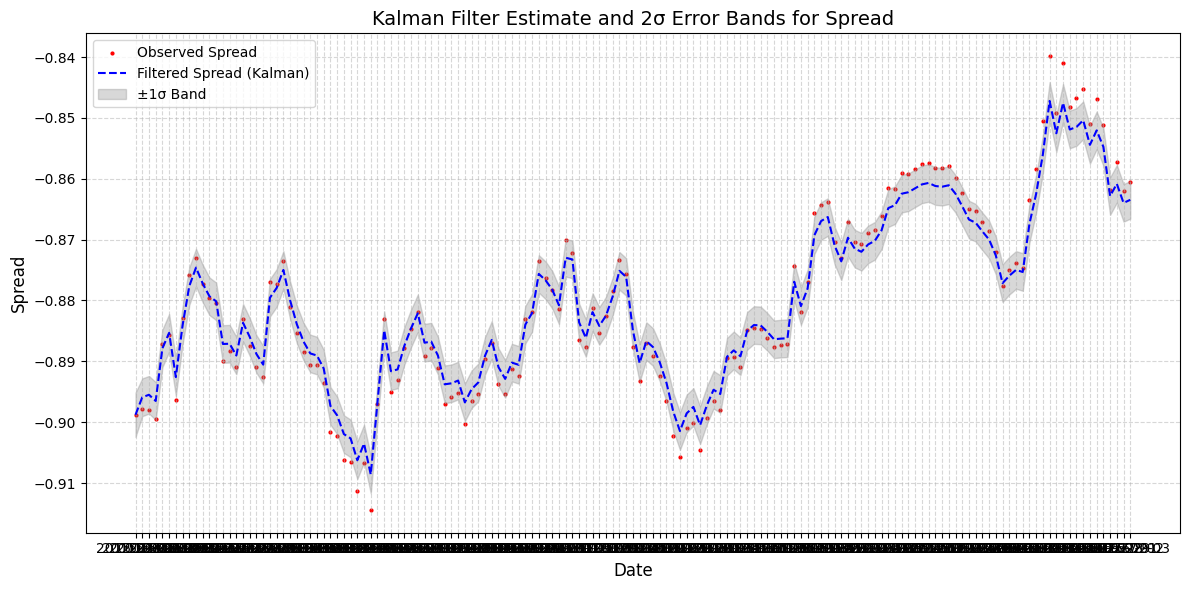

In [43]:
# Compute upper and lower bands
upper_band = x_est + np.sqrt(R_est.values)
lower_band = x_est - np.sqrt(R_est.values)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot observed values
plt.scatter(y_obs.index, y_obs.values, label='Observed Spread', color='red', s = 4)

# Plot estimated (filtered) values
plt.plot(x_est.index, x_est.values, label='Filtered Spread (Kalman)', color='blue', linestyle='--')

# Plot the confidence bands
plt.fill_between(x_est.index, lower_band, upper_band, color='gray', alpha=0.3, label='±1σ Band')

# Formatting
plt.title('Kalman Filter Estimate and 2σ Error Bands for Spread', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Spread', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Display the plot
plt.show()

In [41]:
# return from trading KO_PEP
sum(result["KO_PEP"])

0.08558393665270891